## Loading Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from cf_matrix import make_confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from pprint import pprint

## Loading Data

In [2]:
df = pd.read_csv('data.csv', delimiter = ",")

## Exploring Data

In [3]:
print(f"Number of records: {df.shape[0]}")
print(f"Number of variables: {df.shape[1]}")
df.head()

Number of records: 99198
Number of variables: 26


,Unnamed: 0,ID,ID_status,active,count_reassign,count_opening,count_updated,ID_caller,opened_by,opened_time,...,category_ID,user_symptom,Support_group,support_incharge,Doc_knowledge,confirmation_check,impact,notify,problem_ID,change_request
0,1,INC0000045,New,True,0,0,0,Caller 2403,Opened by 8,29-02-2016 01:16,...,Category 55,Symptom 72,Group 56,?,True,False,2 - Medium,Do Not Notify,?,?
1,3,INC0000045,Resolved,True,0,0,3,Caller 2403,Opened by 8,29-02-2016 01:16,...,Category 55,Symptom 72,Group 56,?,True,False,2 - Medium,Do Not Notify,?,?
2,4,INC0000045,Closed,False,0,0,4,Caller 2403,Opened by 8,29-02-2016 01:16,...,Category 55,Symptom 72,Group 56,?,True,False,2 - Medium,Do Not Notify,?,?
3,6,INC0000047,Active,True,1,0,1,Caller 2403,Opened by 397,29-02-2016 04:40,...,Category 40,Symptom 471,Group 24,Resolver 31,True,False,2 - Medium,Do Not Notify,?,?
4,7,INC0000047,Active,True,1,0,2,Caller 2403,Opened by 397,29-02-2016 04:40,...,Category 40,Symptom 471,Group 24,Resolver 31,True,False,2 - Medium,Do Not Notify,?,?


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99198 entries, 0 to 99197
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          99198 non-null  int64 
 1   ID                  99198 non-null  object
 2   ID_status           99198 non-null  object
 3   active              99198 non-null  bool  
 4   count_reassign      99198 non-null  int64 
 5   count_opening       99198 non-null  int64 
 6   count_updated       99198 non-null  int64 
 7   ID_caller           99198 non-null  object
 8   opened_by           99198 non-null  object
 9   opened_time         99198 non-null  object
 10  Created_by          99198 non-null  object
 11  created_at          99198 non-null  object
 12  updated_by          99198 non-null  object
 13  updated_at          99198 non-null  object
 14  type_contact        99198 non-null  object
 15  location            99198 non-null  object
 16  category_ID         99

* The dataset has 99.198 observations and 126 variables. 
* __impact__ is the target variable and the rest is independent variables. 
* This is a classification problem since the target has categories.

### Checking the target variable

In [5]:
df.impact.value_counts(normalize=True)

2 - Medium    0.947942
3 - Low       0.027420
1 - High      0.024638
Name: impact, dtype: float64

* The target variable, _impact_ has 3 unique categories.
* Most of the incidents were classified as medium impact.

### Mapping ordinal features

* The impact variable has ordinal order from higher impact to lower impact. I will convert them into numeric format. It is a process which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. The categorical value represents the numerical value of the entry in the dataset.

In [6]:
impact_mapping = {'1 - High': 0,
                    '2 - Medium': 1,
                    '3 - Low': 2}

df['impact'] = df['impact'].map(impact_mapping)

In [7]:
# reverse mapping
# inv_impact_mapping = {v: k for k, v in impact_mapping.items()}
# df['impact'].map(inv_impact_mapping)

### Missing Values

In [8]:
df.isnull().sum()

Unnamed: 0            0
ID                    0
ID_status             0
active                0
count_reassign        0
count_opening         0
count_updated         0
ID_caller             0
opened_by             0
opened_time           0
Created_by            0
created_at            0
updated_by            0
updated_at            0
type_contact          0
location              0
category_ID           0
user_symptom          0
Support_group         0
support_incharge      0
Doc_knowledge         0
confirmation_check    0
impact                0
notify                0
problem_ID            0
change_request        0
dtype: int64

* The dataset does not have any missing values.

### Descriptive Statistics

In [9]:
df.describe()

,Unnamed: 0,count_reassign,count_opening,count_updated,impact
count,99198.000000,99198.000000,99198.000000,99198.000000,99198.000000
mean,70820.997843,1.110426,0.022289,5.096857,1.002782
std,40938.839626,1.751588,0.211605,7.748275,0.228145
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,35382.750000,0.000000,0.000000,1.000000,1.000000
50%,70840.500000,1.000000,0.000000,3.000000,1.000000
75%,106231.500000,1.000000,0.000000,6.000000,1.000000
max,141711.000000,27.000000,8.000000,128.000000,2.000000


* It seems like we don't have enough numeric variables. The variables above are count variables and the target variable.

### Correlation

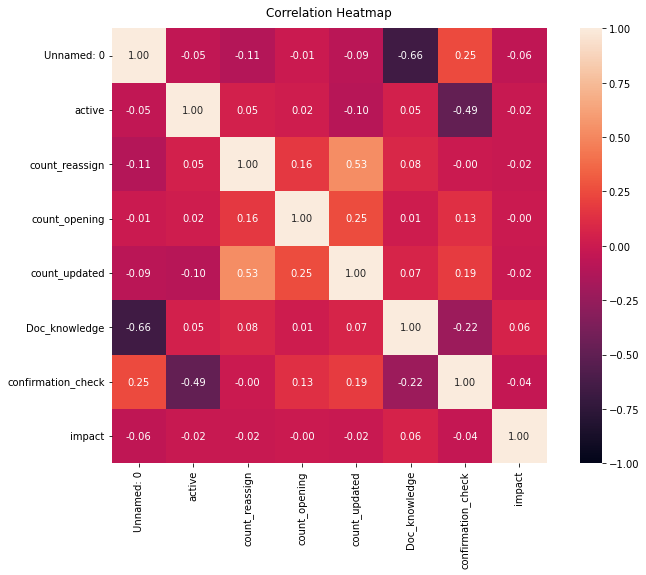

In [10]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cbar=True, square=True, fmt='.2f')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

* It seems like there is no multicollinearity problem with the data.

### Preparing the dataset for modeling

In [11]:
# Dropping manually added variables
df_cleared = df.iloc[:, :18]
# Dropping unnecessary variables
df_cleared = df_cleared.drop(['Unnamed: 0', 'ID'], axis = 1)

In [12]:
# Cleaning variables which have string with numeric values. The code below cleans the strings and keep numeric values.
df_cleared['ID_caller'] = df_cleared['ID_caller'].str.replace(r'\D', '')
df_cleared['opened_by'] = df_cleared['opened_by'].str.replace(r'\D', '')
df_cleared['Created_by'] = df_cleared['Created_by'].str.replace(r'\D', '')
df_cleared['updated_by'] = df_cleared['updated_by'].str.replace(r'\D', '')
df_cleared['location'] = df_cleared['location'].str.replace(r'\D', '')
df_cleared['category_ID'] = df_cleared['category_ID'].str.replace(r'\D', '')
df_cleared['user_symptom'] = df_cleared['user_symptom'].str.replace(r'\D', '')


In [13]:
# Changing data types of timestamps
df_cleared['opened_time'] =  pd.to_numeric(pd.to_datetime(df_cleared['opened_time'], format='%d-%m-%Y %H:%M', errors='coerce'))
df_cleared['created_at'] =  pd.to_numeric(pd.to_datetime(df_cleared['created_at'], format='%d-%m-%Y %H:%M', errors='coerce'))
df_cleared['updated_at'] =  pd.to_numeric(pd.to_datetime(df_cleared['updated_at'], format='%d-%m-%Y %H:%M', errors='coerce'))

In [14]:
# Mapping categorical variables for modeling
status_mapping = {'New':1, 'Resolved':2, 'Closed':3, 'Active':4, 'Awaiting User Info':5,
       'Awaiting Problem':6, 'Awaiting Vendor':7, 'Awaiting Evidence':8, '-100':9}

df_cleared['ID_status'] = df_cleared['ID_status'].map(status_mapping)

In [15]:
contact_mapping = {'Phone': 1,
                    'Email': 2,
                    'Self service': 3,
                    'Direct opening': 4,
                    'IVR': 5}

df_cleared['type_contact'] = df_cleared['type_contact'].map(contact_mapping)

In [16]:
df_cleared['active'] = df_cleared['active'] * 1

In [19]:
df_cleared.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df_cleared['impact'] = df['impact']
df_cleared.dropna(inplace=True)

## Build Model

The code below splits dataset for train the model and test the validity of the model. 20% of dataset will be used for validation.

In [22]:
X = df_cleared.drop('impact', axis=1).values
y = df_cleared['impact'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)
print(X_train.shape); print(X_test.shape)

(36660, 16)
(9165, 16)


## Performance Metric

**Macro avg =** Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

**Weighted avg =** Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

**`WARNING`** Since our dataset is imbalanced and the most important goal is correctly predict higher impact, then higher recall is better for each class because the recall rate is penalized whenever a false negative is predicted. So, the weighted avg recall and weighted avg f1-score are the most important metrics for whole model. 

# Modelling

In this part, some of the traditional statistical techniques and machine learning methods will be used for modeling.

* kNN
* LDA
* Naive Bayes
* Decision Tree
* Random Forest
* XGBoost

## kNN

In [23]:
%%time
knn= KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
y_train_pred= knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)

Wall time: 3.94 s


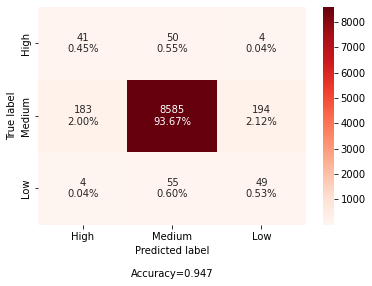

In [24]:
knn_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['High', 'Medium', 'Low']
make_confusion_matrix(knn_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [25]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.432     0.180     0.254       228
           1      0.958     0.988     0.973      8690
           2      0.454     0.198     0.276       247

    accuracy                          0.947      9165
   macro avg      0.614     0.455     0.501      9165
weighted avg      0.931     0.947     0.936      9165



## LDA

In [26]:
%%time
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(X_train, y_train)
y_train_pred = lda_model.predict(X_train)
y_test_pred = lda_model.predict(X_test)

Wall time: 339 ms


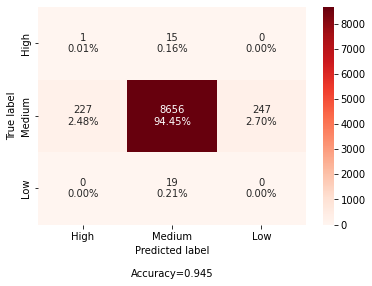

In [27]:
lda_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['High', 'Medium', 'Low']
make_confusion_matrix(lda_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [28]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.062     0.004     0.008       228
           1      0.948     0.996     0.971      8690
           2      0.000     0.000     0.000       247

    accuracy                          0.945      9165
   macro avg      0.337     0.333     0.327      9165
weighted avg      0.901     0.945     0.921      9165



## Naive Bayes

In [29]:
%%time
# training the model on training set 
nb = GaussianNB() 
nb_model = nb.fit(X_train, y_train) 
y_train_pred = nb_model.predict(X_train)

# making predictions on the testing set 
y_test_pred = nb_model.predict(X_test) 

Wall time: 266 ms


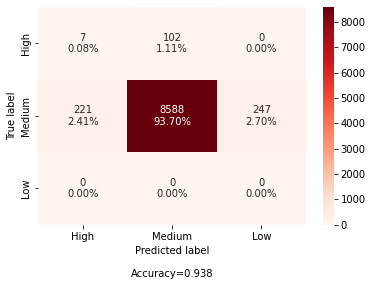

In [30]:
nb_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['High', 'Medium', 'Low']
make_confusion_matrix(nb_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [31]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.064     0.031     0.042       228
           1      0.948     0.988     0.968      8690
           2      0.000     0.000     0.000       247

    accuracy                          0.938      9165
   macro avg      0.338     0.340     0.336      9165
weighted avg      0.901     0.938     0.919      9165



c:\Users\80300609\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\80300609\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\80300609\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

## Tree

In [32]:
%%time
dt = DecisionTreeClassifier()
dt_model = dt.fit(X_train,y_train)
y_train_pred= dt_model.predict(X_train)

#Predict the response for test dataset
y_test_pred = dt_model.predict(X_test)

Wall time: 510 ms


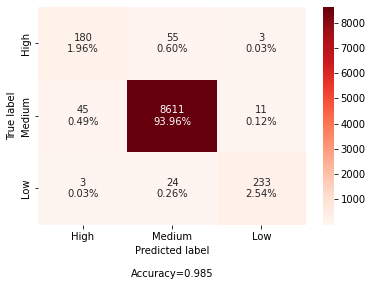

In [33]:
dt_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['High', 'Medium', 'Low']
make_confusion_matrix(dt_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [34]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.756     0.789     0.773       228
           1      0.994     0.991     0.992      8690
           2      0.896     0.943     0.919       247

    accuracy                          0.985      9165
   macro avg      0.882     0.908     0.895      9165
weighted avg      0.985     0.985     0.985      9165



## Random Forest

In [35]:
%%time
rf = RandomForestClassifier(n_estimators=20, random_state=0)
model_rf = rf.fit(X_train, y_train)
y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)

Wall time: 1.36 s


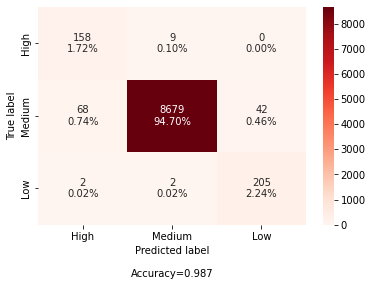

In [36]:
rf_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['High', 'Medium', 'Low']
make_confusion_matrix(rf_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [37]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.946     0.693     0.800       228
           1      0.987     0.999     0.993      8690
           2      0.981     0.830     0.899       247

    accuracy                          0.987      9165
   macro avg      0.971     0.841     0.897      9165
weighted avg      0.986     0.987     0.986      9165



## XGBOOST

In [38]:
%%time
XGBoost = xgb.XGBClassifier()
xgb_model = XGBoost.fit(X_train, y_train)
y_train_pred= xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

Wall time: 6.13 s


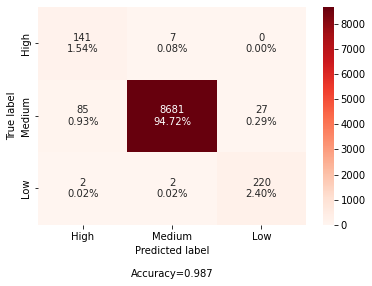

In [39]:
xgb_cm_te = confusion_matrix(y_test_pred, y_test)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ['High', 'Medium', 'Low']
make_confusion_matrix(xgb_cm_te, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Reds')

In [40]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.953     0.618     0.750       228
           1      0.987     0.999     0.993      8690
           2      0.982     0.891     0.934       247

    accuracy                          0.987      9165
   macro avg      0.974     0.836     0.892      9165
weighted avg      0.986     0.987     0.985      9165



Based on the weighed average recall and weighted average f1-score, the best techniques are Random Forest, XGBoost and Decision Tree, respectively.
In further steps, these models can be tuned to find the best parameters and models.

### Feature Importance

Let's see which variables are the better at prediction of target variable __*impact*__.

In [43]:
xgb_model.feature_importances_
feature_importance_df = pd.DataFrame(list(zip(xgb_model.feature_importances_, df.drop(['impact'], axis = 1))))
feature_importance_df.columns = ['feature.importance', 'feature']
feat_sorted = feature_importance_df.sort_values(by='feature.importance', ascending=False)
feat_sorted

,feature.importance,feature
8,0.179904,opened_by
6,0.127092,count_updated
7,0.087955,ID_caller
3,0.075073,active
9,0.066905,opened_time
14,0.064890,type_contact
5,0.062118,count_opening
13,0.056815,updated_at
15,0.052563,location
2,0.047683,ID_status


<AxesSubplot:xlabel='feature'>

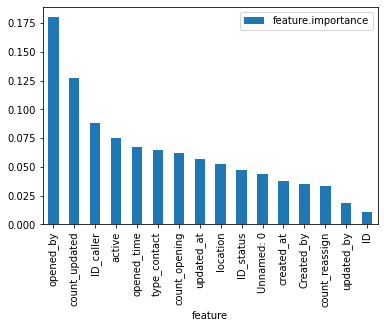

In [44]:
feat_sorted.plot(kind='bar', x='feature')

It seems like the most important features for classifying impact are;

* The user who reported the incidents. It means that some users have higher priority.
* Number of incident updates until that moment. It might be the reason that approaches to solve the incident didn't work. So, solving the incident becomes important.
* Identifier of the user affected. So, some users' incidents have higher impact and IT team wants to solve it asap.
* Lastly, status of the incident is another important feature.